In [2]:
import json
from datasets import load_dataset, Dataset
from PIL import Image, ImageDraw


def transform_result(result, img_id, exclude_classes=[]):
    annotations = [
        r
        for r in result["annotations"]
        if r["image_id"] == img_id
        if r["category_id"] not in exclude_classes
    ]
    new_result = {
        "image_id": img_id,
        "image": Image.open(data_path + "/" + result["images"][img_id]["file_name"]),
        "width": result["images"][img_id]["width"],
        "height": result["images"][img_id]["height"],
        "objects": {
            "id": [a["id"] for a in annotations],
            "area": [a["area"] for a in annotations],
            "bbox": [a["bbox"] for a in annotations],
            "category": [a["category_id"] for a in annotations],
        },
    }

    return new_result

In [3]:
data_path = "../data"

with open(data_path + "/result.json", "r") as f:
    angebot = json.load(f)
rando_str = 45
angebot_dataset = Dataset.from_list(
    [transform_result(angebot, i, []) for i in range(len(angebot["images"]))]
)


In [4]:
def draw_bbox(img, bbox, color="red", width=3):
    draw = ImageDraw.Draw(img)
    draw.rectangle(bbox, outline=color, width=width)
    return img

In [5]:
def find_inside_boxes(dataset_row, core_bbox):
    bbox = (core_bbox[0], core_bbox[1], core_bbox[0]+core_bbox[2], core_bbox[1]+core_bbox[3])
    img = dataset_row['image'].crop(bbox)
    inside_bboxes_and_classes = [([b[0]-bbox[0], b[1] - bbox[1], (b[0]+b[2]) - bbox[0],  (b[1]+b[3]) - bbox[1]],c)
                     for b,c in zip(dataset_row['objects']['bbox'], dataset_row['objects']['category']) 
                     if b[0] >= bbox[0] and b[1] >= bbox[1] and b[0]+b[2] <= bbox[2] and b[1]+b[3] <= bbox[3] and c != 2]
    inside_boxes = []
    for inside_bboxes,_ in inside_bboxes_and_classes:
      temp_bbox = [b for b in inside_bboxes]
      if inside_bboxes[0]+ inside_bboxes[2] > img.width:
        temp_bbox[2] = inside_bboxes[2] - (inside_bboxes[2]-img.width)
      if inside_bboxes[1]+ inside_bboxes[3] > img.height:
        temp_bbox[3] =inside_bboxes[3] - (inside_bboxes[3]-img.height)
      inside_boxes.append(temp_bbox)
    return inside_boxes, [inside_classe for _,inside_classe in inside_bboxes_and_classes], img
 
def handle_row(dataset_row):
    core_bboxes = [bbox 
               for bbox,category in zip(dataset_row['objects']['bbox'], dataset_row['objects']['category']) 
               if category == 2]
    inside_bboxes_all = []
    inside_classes_all = []
    img_all = []
    for core_bbox in core_bboxes:
        inside_bboxes, inside_classes, img = find_inside_boxes(dataset_row, core_bbox)
        inside_bboxes_all.append(inside_bboxes)
        inside_classes_all.append(inside_classes)
        img_all.append(img)
        
    return [
        {
            'image_id': f"{dataset_row['image_id']}_{img_id}",
            'image':img,
            'width': img.width,
            'height': img.height,
            'objects': {
                'bbox': inside_bboxes,
                'category': inside_classes
            },
        }
        for img_id,(inside_bboxes, inside_classes, img) in enumerate(zip(inside_bboxes_all, inside_classes_all, img_all))
    ]
        

In [6]:
angebot_sub_dataset = Dataset.from_list(
    [sub_row  
     for row in angebot_dataset 
     for sub_row in handle_row(row)]
)

In [7]:
angebot_sub_dataset[0]

{'image_id': '0_0',
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=740x944>,
 'width': 740,
 'height': 944,
 'objects': {'bbox': [[201.4727603856566,
    339.98923283983834,
    481.6490726333014,
    481.651413189771],
   [305.3606998654106, 66.10901749663515, 740.0, 248.6958277254373],
   [317.95289367429353, 277.028263795424, 740.0, 327.3970390309556]],
  'category': [1, 3, 0]}}

In [8]:
row = angebot_sub_dataset[70]
img = row['image']
for bbox in row['objects']['bbox']:
    img = draw_bbox(img, bbox)

In [9]:
row['objects']['bbox']


[[156.56013164071982, 53.062873717021574, 363.0, 162.89570617382094]]

In [10]:
img.width

363

In [11]:
img.height

489

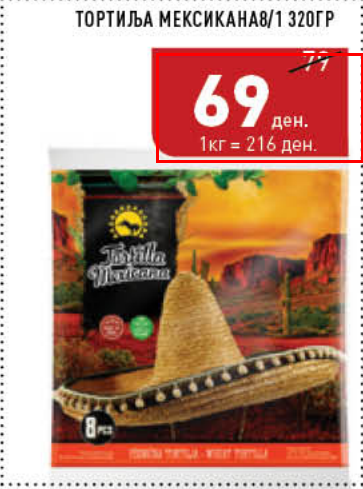

In [12]:
img

In [13]:
for row in angebot_sub_dataset:
    img = row['image']
    for bboxes in row['objects']['bbox']:
        if (img.width < bboxes[2] or img.height < bboxes[3]) or (img.width < bboxes[0] or img.height < bboxes[1]):
            bbox[2] = img.width - 1

In [14]:
for row in angebot_sub_dataset:
    img = row['image']
    for bboxes in row['objects']['bbox']:
        if (img.width < bboxes[0] + bboxes[2] or img.height < bboxes[1] + bboxes[3]):
            print('image_id',row['image_id'])
            print('bboxes',bboxes)
            print('image_dim',img.width, img.height)
            print('sums',bboxes[0] +bboxes[2], bboxes[1] + bboxes[3])
            break
    break

image_id 0_0
bboxes [305.3606998654106, 66.10901749663515, 740.0, 248.6958277254373]
image_dim 740 944
sums 1045.3606998654107 314.80484522207246


In [19]:
overflow = [bb for bb in angebot_sub_dataset[0]['objects']['bbox'] if bb[0] + bb[2] > angebot_sub_dataset[0]['width'] or bb[1] + bb[3] > angebot_sub_dataset[0]['height']]

In [17]:

angebot_sub_dataset[0]['image'].width

740

In [18]:

angebot_sub_dataset[0]['image'].height

944

In [25]:
overflow[0][0] + (overflow[0][0] + overflow[0][2] - angebot_sub_dataset[0]['image'].width)

610.7213997308213

In [24]:
overflow[0][0] + overflow[0][2] - angebot_sub_dataset[0]['image'].width

305.36069986541065

In [43]:
nr = [overflow[0][0],overflow[0][1],angebot_sub_dataset[0]['image'].width-5, overflow[0][3]]

In [33]:
overflow[0][2] - angebot_sub_dataset[0]['image'].width+1

1.0

In [37]:
nr

[305.3606998654106, 66.10901749663515, 740, 248.6958277254373]

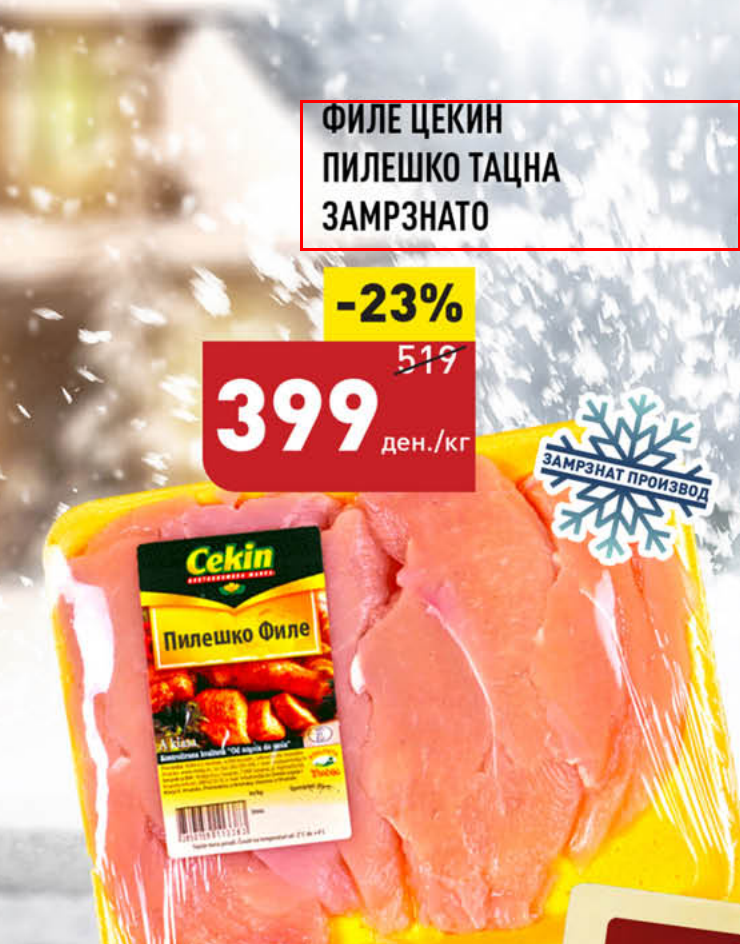

In [71]:
draw_bbox(angebot_sub_dataset[0]['image'], (300,100,740,250))